## Sparklink demo 

In this demo we de-duplicate a small dataset.

The purpose is to provide an end-to-end example of how to use the package

I print the output at each stage using `spark_dataframe.show()`.  This is for instructional purposes only - it degrades performance and shouldn't be used in a production setting.

## Step 1:  Imports and setup

The following is just boilerplate code that sets up the Spark session and sets some other non-essential configuration options

In [1]:
import pandas as pd 
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

In [2]:
import logging 
logging.basicConfig()

# Set to DEBUG if you want sparklink to log the SQL statements it's executing under the hood
logging.getLogger("sparklink").setLevel(logging.INFO)

In [3]:
from pyspark.context import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StructType
import pyspark.sql.functions as f

conf=SparkConf()

# Load in a jar that provides extended string comparison functions such as Jaro Winkler.
# Sparklink 
conf.set('spark.driver.extraClassPath', 'jars/scala-udf-similarity-0.0.6.jar')
conf.set('spark.jars', 'jars/scala-udf-similarity-0.0.6.jar')   


# WARNING:
# These config options are appropriate only if you're running Spark locally!!!
conf.set('spark.driver.memory', '4g')
conf.set("spark.sql.shuffle.partitions", "8") 

sc = SparkContext.getOrCreate(conf=conf)

spark = SparkSession(sc)

 # Register UDFs
from pyspark.sql import types
spark.udf.registerJavaFunction('jaro_winkler_sim', 'uk.gov.moj.dash.linkage.JaroWinklerSimilarity', types.DoubleType())
spark.udf.registerJavaFunction('Dmetaphone', 'uk.gov.moj.dash.linkage.DoubleMetaphone', types.StringType())

## Step 2:  Configure sparklink using the `settings` object

Most of `sparklink` configuration options are stored in a settings dictionary.  This dictionary allows significant customisation, and can therefore get quite complex.  

Customisation overrides default values built into sparklink.  For the purposes of this demo, we will specify a simple settings dictionary, which means we will be relying on these sensible defaults.

To help with authoring and validation of the settings dictionary, we have written a [json schema](https://json-schema.org/), which can be found [here](https://github.com/moj-analytical-services/sparklink/blob/dev/sparklink/files/settings_jsonschema.json).  We also provide an tool for helping to author valid settings dictionaries, which includes tooltips and autocomplete, which you can find [here](https://robinlinacre.com/simple_sparklink_settings_editor/).



In [20]:
settings = {
    "proportion_of_matches": 0.5,
    "link_type": "dedupe_only",
    "blocking_rules": [
        'l.first_name = r.first_name',
        'l.surname = r.surname',
        'l.dob = r.dob'
    ],
    "comparison_columns": [
        {
            "col_name": "first_name",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "surname",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "dob"
        },
        {
            "col_name": "city"
        },
        {
            "col_name": "email"
        }
    ]
    
}

In words, this setting dictionary says:
- We are performing a deduplication task (the other options are `link_only`, or `link_and_dedupe`)
- The initial value (prior belief) for the proportion of matches amongst comparisons is 0.5 (50% of comparisons that result from the blocking rules are matches).
- We are going generate comparisons subject to the blocking rules contained in the specified array
- When comparing records, we will use information from the `first_name`, `surname`, `dob`, `city` and `email` columns to compute a match score.
- For `first_name` and `surname`, string comparisons will have three levels:
    - Level 2: Strings are (almost) exactly the same
    - Level 1: Strings are similar 
    - Level 0: No match


## Step 3:  Read in data and create comparisons using blocking rules

In [21]:
df = spark.read.parquet("data/fake_1000.parquet")
df.show(5)

+---------+----------+-------+----------+------+--------------------+-----+
|unique_id|first_name|surname|       dob|  city|               email|group|
+---------+----------+-------+----------+------+--------------------+-----+
|        0|    Julia |   null|2015-10-29|London| hannah88@powers.com|    0|
|        1|    Julia | Taylor|2015-07-31|London| hannah88@powers.com|    0|
|        2|    Julia | Taylor|2016-01-27|London| hannah88@powers.com|    0|
|        3|    Julia | Taylor|2015-10-29|  null|  hannah88opowersc@m|    0|
|        4|      oNah| Watson|2008-03-23|Bolton|matthew78@ballard...|    1|
+---------+----------+-------+----------+------+--------------------+-----+
only showing top 5 rows



In [22]:
from sparklink.blocking import block_using_rules
from sparklink.gammas import complete_settings_dict
settings = complete_settings_dict(settings)
df_comparison = block_using_rules(settings, df=df, spark=spark)
df_comparison.show(5)

+-----------+-----------+------------+------------+---------+---------+----------+----------+------+------+-------------------+-------------------+
|unique_id_l|unique_id_r|first_name_l|first_name_r|surname_l|surname_r|     dob_l|     dob_r|city_l|city_r|            email_l|            email_r|
+-----------+-----------+------------+------------+---------+---------+----------+----------+------+------+-------------------+-------------------+
|          0|          3|      Julia |      Julia |     null|   Taylor|2015-10-29|2015-10-29|London|  null|hannah88@powers.com| hannah88opowersc@m|
|          0|          2|      Julia |      Julia |     null|   Taylor|2015-10-29|2016-01-27|London|London|hannah88@powers.com|hannah88@powers.com|
|          0|          1|      Julia |      Julia |     null|   Taylor|2015-10-29|2015-07-31|London|London|hannah88@powers.com|hannah88@powers.com|
|          1|          3|      Julia |      Julia |   Taylor|   Taylor|2015-07-31|2015-10-29|London|  null|hanna

## Step 3:  Compute Fellegi Sunter comparison vectors from the table of comparisons

Columns are assumed to be strings by default.  See the 'comparison vector settings' notebook for details of configuration options.

In [23]:
from sparklink.gammas import add_gammas

df_gammas = add_gammas(df_comparison, settings, spark, include_orig_cols = True)
df_gammas.persist()
df_gammas.show(5)

+-----------+-----------+------------+------------+---------+---------+----------+----------+------+------+-------------------+-------------------+-------+-------+-------+-------+-------+
|unique_id_l|unique_id_r|first_name_l|first_name_r|surname_l|surname_r|     dob_l|     dob_r|city_l|city_r|            email_l|            email_r|gamma_0|gamma_1|gamma_2|gamma_3|gamma_4|
+-----------+-----------+------------+------------+---------+---------+----------+----------+------+------+-------------------+-------------------+-------+-------+-------+-------+-------+
|          0|          3|      Julia |      Julia |     null|   Taylor|2015-10-29|2015-10-29|London|  null|hannah88@powers.com| hannah88opowersc@m|      2|     -1|      1|     -1|      0|
|          0|          2|      Julia |      Julia |     null|   Taylor|2015-10-29|2016-01-27|London|London|hannah88@powers.com|hannah88@powers.com|      2|     -1|      0|      1|      1|
|          0|          1|      Julia |      Julia |     null

## Step 4:  Initialise parameters (m and u probabilities)

In [24]:
from sparklink.params import Params 
params = Params(settings)

# Note all initial parameters are customisable - see the  'comparison vector settings' notebook for details of configuration options.

In [25]:
#  Note that the params object has a formatted, human-readable __repr__ representation when you print it
params

λ (proportion of matches) = 0.5
------------------------------------
gamma_0: Comparison of first_name

Probability distribution of gamma values amongst matches:
    value 0: 0.100000 (level represents lowest category of string similarity)
    value 1: 0.200000 
    value 2: 0.700000 (level represents highest category of string similarity)

Probability distribution of gamma values amongst non-matches:
    value 0: 0.700000 (level represents lowest category of string similarity)
    value 1: 0.200000 
    value 2: 0.100000 (level represents highest category of string similarity)
------------------------------------
gamma_1: Comparison of surname

Probability distribution of gamma values amongst matches:
    value 0: 0.100000 (level represents lowest category of string similarity)
    value 1: 0.200000 
    value 2: 0.700000 (level represents highest category of string similarity)

Probability distribution of gamma values amongst non-matches:
    value 0: 0.700000 (level represents lowes

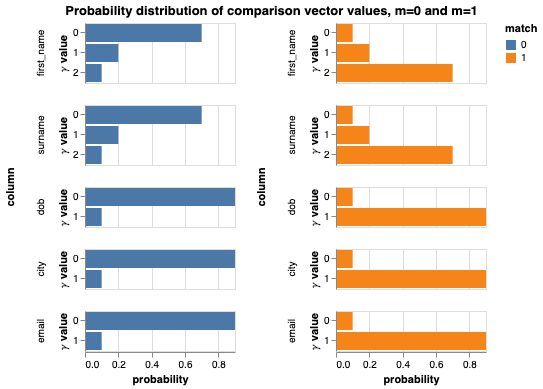

In [26]:
# Note there are various graphical representations of the information contained in parameters, such as:
params.probability_distribution_chart()

## Step 5:  Repeatedly apply expectation and maximisation step to improve parameter estimates

In [27]:
from sparklink.iterate import iterate
logging.getLogger("sparklink").setLevel(logging.INFO)
df_e = iterate(df_gammas, spark, params, num_iterations=20, compute_ll=True)

INFO:sparklink.expectation_step:
Log likelihood for iteration 0:  -22022.17073033113

INFO:sparklink.expectation_step:
Log likelihood for iteration 1:  -15746.226403305649

INFO:sparklink.expectation_step:
Log likelihood for iteration 2:  -15521.787360601704

INFO:sparklink.expectation_step:
Log likelihood for iteration 3:  -15474.51383191972

INFO:sparklink.expectation_step:
Log likelihood for iteration 4:  -15458.77874371436

INFO:sparklink.expectation_step:
Log likelihood for iteration 5:  -15450.728664992195

INFO:sparklink.expectation_step:
Log likelihood for iteration 6:  -15445.65232979209

INFO:sparklink.expectation_step:
Log likelihood for iteration 7:  -15442.149315795372

INFO:sparklink.expectation_step:
Log likelihood for iteration 8:  -15439.608912537664

INFO:sparklink.expectation_step:
Log likelihood for iteration 9:  -15437.702593455539

INFO:sparklink.expectation_step:
Log likelihood for iteration 10:  -15436.23335290754

INFO:sparklink.expectation_step:
Log likelihood

## Step 6: Inspect results 



In [28]:
# Inspect main dataframe that contains the match scores
df_e.toPandas().sample(5)

,unique_id_l,unique_id_r,first_name_l,first_name_r,surname_l,surname_r,dob_l,dob_r,city_l,city_r,email_l,email_r,gamma_0,gamma_1,gamma_2,gamma_3,gamma_4,prob_gamma_0_non_match,prob_gamma_0_match,prob_gamma_1_non_match,prob_gamma_1_match,prob_gamma_2_non_match,prob_gamma_2_match,prob_gamma_3_non_match,prob_gamma_3_match,prob_gamma_4_non_match,prob_gamma_4_match,match_probability
2944,137,863,None,None,Jones,Jones,1980-06-23,1983-06-19,London,None,trobinson@garza.com,smyers@andersen-lee.com,-1,2,0,-1,0,1.000000,1.000000,0.684782,0.495868,0.988103,0.204063,1.000000,1.000000,0.988285,0.314853,0.030535
3399,224,329,Amber,Eliza,Smith,Smith,2003-05-12,1991-02-26,Sunderland,Sumhatpton,barrerakevin@sherman.org,None,0,2,0,0,-1,0.512266,0.434922,0.684782,0.495868,0.988103,0.204063,0.857744,0.320819,1.000000,1.000000,0.030439
1479,545,546,Freddie,Freddie,Palmer,Palmer,2008-08-10,2008-08-10,Belfast,Belfast,ndavis@miller-mccoy.org,ndavis@miller-mccoy.org,2,2,1,1,1,0.487354,0.478992,0.684782,0.495868,0.011897,0.795937,0.142256,0.679181,0.011715,0.685147,0.999886
4280,516,724,Ali e,Sienna,Taylor,Taylor,2005-06-20,2005-06-04,London,None,michellejackson@smith-trujillo.com,javierfrederi@kkelly.org,0,2,0,-1,0,0.512266,0.434922,0.684782,0.495868,0.988103,0.204063,1.000000,1.000000,0.988285,0.314853,0.026045
4358,551,554,None,Henry,Owen,Owen,2016-05-16,2016-03-06,Kingston-upon-Hull,Kingston-upon-Hull,nicholasbutler@jackson.net,nicholasbutler@jackson.net,-1,2,0,1,1,1.000000,1.000000,0.684782,0.495868,0.988103,0.204063,0.142256,0.679181,0.011715,0.685147,0.965042


Note that the `params` object is updated during the process of iteration.

This means that if we inspect it again, we will see a new set of parameters - those that result from the application of the expectation maximiastion algorithm

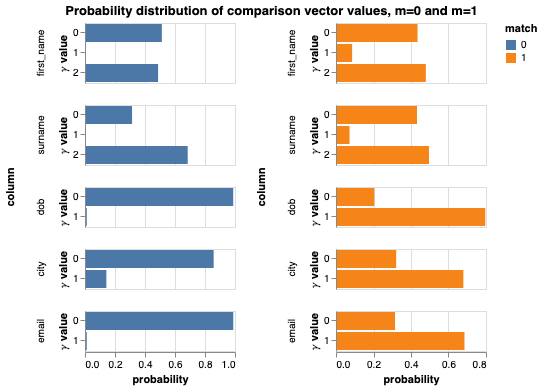

In [29]:
params.probability_distribution_chart()

An alternative representation of the parameters displays them in terms of the effect different values in the comparison vectors have on the match probability:

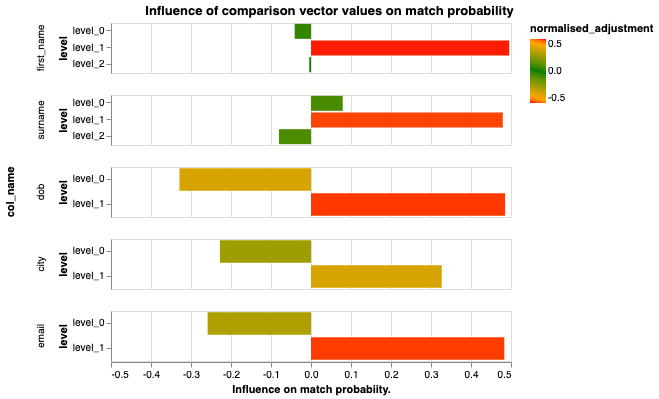

In [30]:
params.adjustment_factor_chart()

In [31]:
# If charts aren't displaying correctly in your notebook, you can write them to a file (by default sparklink_charts.html)
params.all_charts_write_html_file()

You can also generate a report which explains how the match probability was computed for an individual comparison row.  

Note that you need to convert the row to a dictionary for this to work

In [32]:
from sparklink.intuition import intuition_report
row_dict = df_e.toPandas().sample(1).to_dict(orient="records")[0]
print(intuition_report(row_dict, params))


Initial probability of match (prior) = λ = 0.39798885583877563

Comparison of first_name.  Values are:
first_name_l: Alnxader 
first_name_r: Russell
Comparison has 3 levels
𝛾 for this comparison = gamma_0 = 0
Amongst matches, P(𝛾 = 0.4349217414855957):
Amongst non matches, P(𝛾 = 0.5122657418251038):
Adjustment factor = p1/(p1 + p2) = 0.4591717575969395
New probability of match (updated belief): 0.35950128588869507

Comparison of surname.  Values are:
surname_l: Russell
surname_r: Alexander 
Comparison has 3 levels
𝛾 for this comparison = gamma_1 = 0
Amongst matches, P(𝛾 = 0.43201279640197754):
Amongst non matches, P(𝛾 = 0.31371554732322693):
Adjustment factor = p1/(p1 + p2) = 0.5793165836287043
New probability of match (updated belief): 0.4359634055302436

Comparison of dob.  Values are:
dob_l: 1982-03-24
dob_r: 1982-03-24
Comparison has 2 levels
𝛾 for this comparison = gamma_2 = 1
Amongst matches, P(𝛾 = 0.7959368228912354):
Amongst non matches, P(𝛾 = 0.011897263117134571):
Adjustment

## Step 7: Term frequency adjustments

Sparklink enables you to make adjustments for term frequency on any number of columns

This enables match probabilities to be adjusted for e.g. the fact John Smith is more prevalent than Robin Linacre

In [33]:
from sparklink.term_frequencies import make_adjustment_for_term_frequencies
df_e_adj = make_adjustment_for_term_frequencies(df_e, params, settings, retain_adjustment_columns=True, spark=spark)

In [34]:
pdtf = df_e_adj.toPandas()
sam = pdtf.sample(10)
sam[["match_probability", "tf_adjusted_match_prob"] + list(pdtf.columns)]

,match_probability,tf_adjusted_match_prob,unique_id_l,unique_id_r,first_name_l,first_name_r,surname_l,surname_r,dob_l,dob_r,city_l,city_r,email_l,email_r,gamma_0,gamma_1,gamma_2,gamma_3,gamma_4,prob_gamma_0_non_match,prob_gamma_0_match,prob_gamma_1_non_match,prob_gamma_1_match,prob_gamma_2_non_match,prob_gamma_2_match,prob_gamma_3_non_match,prob_gamma_3_match,prob_gamma_4_non_match,prob_gamma_4_match,match_probability,first_name_adj,surname_adj,tf_adjusted_match_prob
4939,0.999931,0.999931,131,132,Edward,Lewis,Lewis,Edward,2005-05-26,2005-05-26,London,London,whitakernichole@booth.com,whitakernichole@booth.com,0,0,1,1,1,0.512266,0.434922,0.313716,0.432013,0.011897,0.795937,0.142256,0.679181,0.011715,0.685147,0.999931,0.500000,0.500000,0.999931
2619,0.009903,0.007586,75,235,Isabella,Chaloett,Cooper,Cooper,1987-11-18,1995-07-11,Stockton-on-Tees,Sunderland,imoore@turner-gnzalze.info,toddsean@wilkins-burton.biz,0,2,0,0,0,0.512266,0.434922,0.684782,0.495868,0.988103,0.204063,0.857744,0.320819,0.988285,0.314853,0.009903,0.500000,0.433184,0.007586
5253,0.957949,0.957949,454,455,Alfi,None,Carter,Crtre,1997-03-13,1997-03-13,London,doLon,jennifermarshall@browning.com,None,-1,0,1,0,-1,1.000000,1.000000,0.313716,0.432013,0.011897,0.795937,0.857744,0.320819,1.000000,1.000000,0.957949,0.500000,0.500000,0.957949
714,0.993390,0.996036,252,258,Mohammed,Mohammed,Owen,Owen,2018-01-14,2018-01-14,Cardiff,Cardiff,None,gkennedy@vincent.com,2,2,1,1,-1,0.487354,0.478992,0.684782,0.495868,0.011897,0.795937,0.142256,0.679181,1.000000,1.000000,0.993390,0.597390,0.529830,0.996036
5661,0.999669,0.999669,935,936,Hodgson,George,George,Hodgson,1980-12-30,1980-12-30,None,Sheffied,lori88@huynh.biz,lori88@huynh.biz,0,0,1,-1,1,0.512266,0.434922,0.313716,0.432013,0.011897,0.795937,1.000000,1.000000,0.011715,0.685147,0.999669,0.500000,0.500000,0.999669
5060,0.860369,0.860369,277,278,Jackson,Lily,Lily,Jackson,2000-07-30,2000-07-30,Mansfield,Mlnsfied,lewischristopher@black-thomas.net,lewischristophr@black-thomas.net,0,0,1,0,0,0.512266,0.434922,0.313716,0.432013,0.011897,0.795937,0.857744,0.320819,0.988285,0.314853,0.860369,0.500000,0.500000,0.860369
1538,0.219402,0.079611,574,899,George,George,Williams,Cook,1981-08-06,1973-03-29,London,London,desek58gibbr.biz,lgonzalez@hicks-lewis.com,2,0,0,1,0,0.487354,0.478992,0.313716,0.432013,0.988103,0.204063,0.142256,0.679181,0.988285,0.314853,0.219402,0.235325,0.500000,0.079611
608,0.055598,0.026228,211,540,Freddie,Freddie,Thompson,Roberts,1999-07-23,2004-11-15,None,Bolton,scottsalinas@hughes-lopez.com,browndonald@mccormick.info,2,0,0,-1,0,0.487354,0.478992,0.313716,0.432013,0.988103,0.204063,1.000000,1.000000,0.988285,0.314853,0.055598,0.313900,0.500000,0.026228
4237,0.030535,0.006657,514,724,None,Sienna,Taylor,Taylor,2005-06-20,2005-06-04,London,None,michellejackson@smith-trujillo.com,javierfrederi@kkelly.org,-1,2,0,-1,0,1.000000,1.000000,0.684782,0.495868,0.988103,0.204063,1.000000,1.000000,0.988285,0.314853,0.030535,0.500000,0.175441,0.006657
4468,0.009903,0.002124,664,750,Ivy,hicMae,Taylor,Taylor,1980-01-13,1993-06-23,Lonon,Brighton,jonesjennmfer@pitt.coi,rhondawilliams@gonzalez-scott.com,0,2,0,0,0,0.512266,0.434922,0.684782,0.495868,0.988103,0.204063,0.857744,0.320819,0.988285,0.314853,0.009903,0.500000,0.175441,0.002124
